In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the 16x16 matrix from an xlsx file
file_path = "/content/tm.xlsx"
TM = pd.read_excel(file_path).iloc[:16, :16]

In [3]:
# Generate a dataset by multiplying it with a random scaling factor
n_seconds = 1501  # 0s to 1500s (inclusive)

dataset = []
for t in range(n_seconds):
    scaling_factor = np.random.uniform(0.75, 1.25, (16, 16))
    scaled_traffic = TM * scaling_factor
    dataset.append(scaled_traffic)

random_seconds = np.random.choice(n_seconds - 5, 30, replace=False)

for sec in random_seconds:
    scaling_factor = [np.random.uniform(0.1, 0.5, (16, 16)), np.random.uniform(1.5, 2, (16, 16))]
    idx = np.random.choice([0, 1])
    for i in range(5):
        dataset[sec + i] = dataset[sec + i] * scaling_factor[idx]

# Extract row 0 and column 1 values of every second --- ToR 0 to 1
data = [ToR[0][1] for ToR in dataset]

In [4]:
# Normalisation with Median
sorted_data = sorted(data)
median = sorted_data[n_seconds // 2]

data = [data / median]
data[-5:]

[array([0.81474675, 0.8237414 , 0.82868012, ..., 0.31581099, 0.34278584,
        1.20733662])]

In [5]:
# Normalize the dataset
scaler = MinMaxScaler()
dataset = np.array(data).reshape(-1, 1)
dataset = scaler.fit_transform(dataset)

# Split the dataset into training and testing sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [6]:
# Create sequences and labels for training
def create_sequences(dataset, look_back = 10):
    sequences, labels = [], []
    for i in range(len(dataset) - look_back):
        sequences.append(dataset[i:i+look_back])
        labels.append(dataset[i+look_back])
    return np.array(sequences), np.array(labels)

look_back = 10  # Window size
train_sequences, train_labels = create_sequences(train_data, look_back)
test_sequences, test_labels = create_sequences(test_data, look_back)
print(train_labels[:5])
print(test_labels[:5])

[[0.30737312]
 [0.37181972]
 [0.3806832 ]
 [0.46054998]
 [0.42216583]]
[[0.41640781]
 [0.41342717]
 [0.3968467 ]
 [0.31922011]
 [0.458151  ]]


In [7]:
from keras.optimizers import Adam

# Build a Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(look_back, 1))))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [8]:
# Train the model
model.fit(train_sequences, train_labels, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
38/38 - 5s - loss: 0.0374 - 5s/epoch - 121ms/step
Epoch 2/10
38/38 - 0s - loss: 0.0147 - 267ms/epoch - 7ms/step
Epoch 3/10
38/38 - 0s - loss: 0.0143 - 277ms/epoch - 7ms/step
Epoch 4/10
38/38 - 0s - loss: 0.0141 - 284ms/epoch - 7ms/step
Epoch 5/10
38/38 - 0s - loss: 0.0137 - 284ms/epoch - 7ms/step
Epoch 6/10
38/38 - 0s - loss: 0.0135 - 279ms/epoch - 7ms/step
Epoch 7/10
38/38 - 0s - loss: 0.0133 - 275ms/epoch - 7ms/step
Epoch 8/10
38/38 - 0s - loss: 0.0131 - 301ms/epoch - 8ms/step
Epoch 9/10
38/38 - 0s - loss: 0.0128 - 282ms/epoch - 7ms/step
Epoch 10/10
38/38 - 0s - loss: 0.0128 - 286ms/epoch - 8ms/step


In [9]:
# Make predictions on test data
test_predictions = model.predict(test_sequences)

# Inverse transform the predictions to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_labels = scaler.inverse_transform(test_labels)
train_labels = scaler.inverse_transform(train_labels)

10/10 [==============================] - 1s 3ms/step


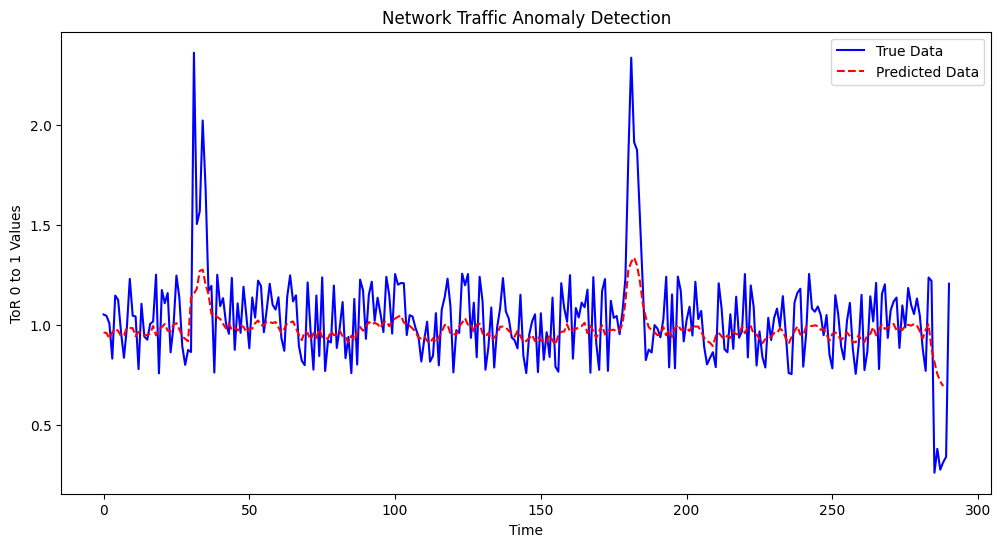

In [11]:
shifted_test_predictions = test_predictions[2:]

# Plot the test data, predicted data, and anomalies
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='True Data', color='blue')
plt.plot(shifted_test_predictions, label='Predicted Data', linestyle='--', color='red')


plt.title('Network Traffic Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('ToR 0 to 1 Values')
plt.legend()
plt.show()

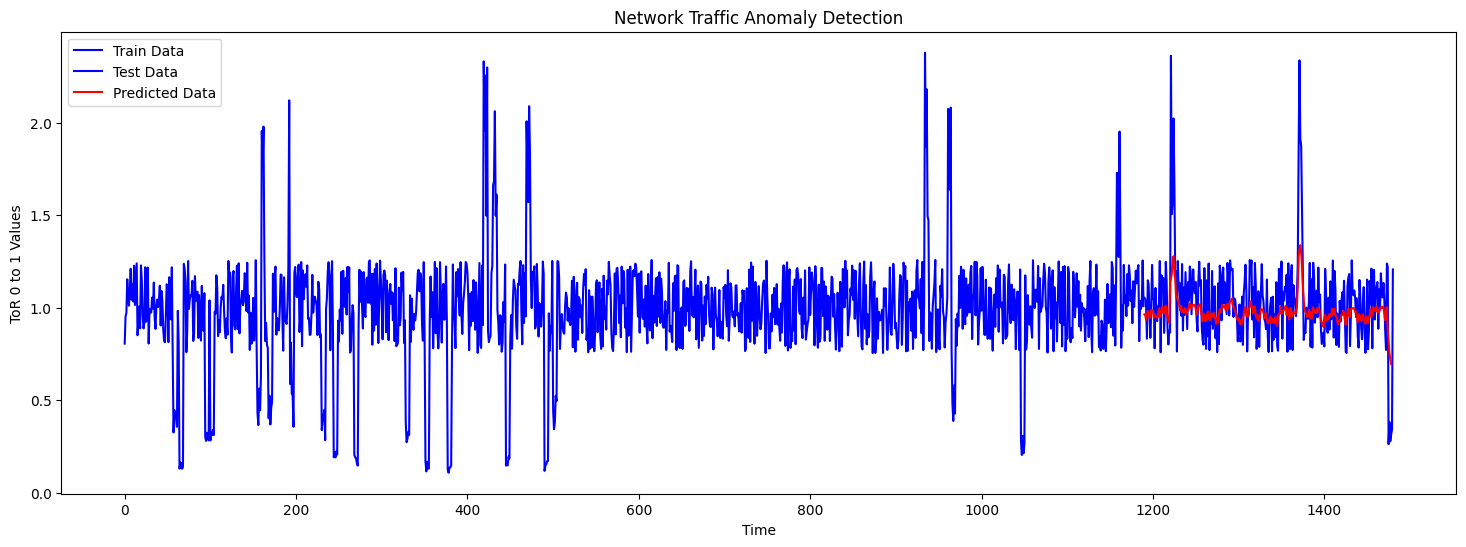

In [12]:
# Assuming train_labels, test_labels, and test_predictions are numpy arrays or lists

# Length of the training data
train_len = len(train_labels)

plt.figure(figsize=(18, 6))
plt.plot(range(train_len), train_labels, label='Train Data', color='blue')
plt.plot(range(train_len, train_len + len(test_labels)), test_labels, label='Test Data', color='blue')
plt.plot(range(train_len, train_len + len(shifted_test_predictions)), shifted_test_predictions, label='Predicted Data', color='red')

plt.title('Network Traffic Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('ToR 0 to 1 Values')
plt.legend()
plt.show()
